In [96]:
'''
Compsci 571 Homework 1
Yilin Gao (yg95)
Programming Question 1 and 2
Python 3.6
'''

'\nCompsci 571 Homework 1\nYilin Gao (yg95)\nProgramming Question 1 and 2\nPython 3.6\n'

In [97]:
"""import mnist dataset with tensorflow"""
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False) # don't need one-hot vector for labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [98]:
"""import libraries"""
import numpy as np
import matplotlib.pyplot as plt
import math

In [99]:
"""DATA PROCESSING"""

'DATA PROCESSING'

In [100]:
# number of data points in the initial dataset
train_full_size = mnist.train.images.shape[0]
test_full_size = mnist.test.images.shape[0]

In [101]:
# append one column of 1s for intercept to training X
train_x_ones_full = np.append(np.ones((train_full_size, 1)), mnist.train.images, axis = 1)
# combine training x and y into one 2D array
train_x_y_full = np.append(train_x_ones_full, mnist.train.labels.reshape(train_full_size, 1), axis = 1)

# append one column of 1s for intercept to testing X
test_x_ones_full = np.append(np.ones((test_full_size, 1)), mnist.test.images, axis = 1)
# combine testing x and y into one 2D array
test_x_y_full = np.append(test_x_ones_full, mnist.test.labels.reshape(test_full_size, 1), axis = 1)

In [102]:
# filter training data with label 4 or 9, and relable 4 to 1, relable 9 to -1
train_x_y_4 = train_x_y_full[(train_x_y_full == 4)[:, -1]]
train_x_y_4[:, -1] = 1
train_x_y_9 = train_x_y_full[(train_x_y_full == 9)[:, -1]]
train_x_y_9[:, -1] = -1
train_x_y = np.append(train_x_y_4, train_x_y_9, axis = 0)
train_size = train_x_y.shape[0]
print('Shape of training data is', train_x_y.shape)

# filter testing data with label 4 or 9, and relable 4 to 1, relable 9 to -1
test_x_y_4 = test_x_y_full[(test_x_y_full == 4)[:, -1]]
test_x_y_4[:, -1] = 1
test_x_y_9 = test_x_y_full[(test_x_y_full == 9)[:, -1]]
test_x_y_9[:, -1] = -1
test_x_y = np.append(test_x_y_4, test_x_y_9, axis = 0)
test_size = test_x_y.shape[0]
print('Shape of testing data is', test_x_y.shape)

Shape of training data is (10761, 786)
Shape of testing data is (1991, 786)


In [103]:
"""HELPER FUNCTIONS"""

'HELPER FUNCTIONS'

In [104]:
'''
helper function
predict yhat for a w and dataset S

parameter w: weight vector, shape = (785, 1)
parameter S: dataset, shape = (n, 786)
'''
def predict_yhat(w, S):
    n = S.shape[0]
    yhat = np.dot(S[:, 0: 785], w)
    yhat[yhat <= 0] = -1
    yhat[yhat > 0] = 1
    yhat = yhat.reshape(n, 1)
    return yhat

In [105]:
'''
helper function for calculating performance measure statistics (accuracy, confusion matrix)
accuracy = 1 - #(yhat != y) / n
confusion matrix:
    TP = np.sum(yhat == 1 && test_x_y[-1] == 1)
    FP = np.sum(yhat == 1 && test_x_y[-1] == -1)
    FN = np.sum(yhat == -1 && test_x_y[-1] == 1)
    TN = np.sum(yhat == -1 && test_x_y[-1] == -1)

parameter y: original label in data, shape = (n, 1)
parameter yhat: predicted label, shape = (n, 1)
return accu, tp, fp, fn, tn
'''
def performance(y, yhat):
    n = y.shape[0]
    y_yhat = np.append(y, yhat, axis = 1)
    # accuracy
    accu = 1 - (np.sum(y != yhat) / n)
    # confusion matrix
    tp = y_yhat[(y_yhat[:, 0] == 1) & (y_yhat[:, 1] == 1)].shape[0]
    fp = y_yhat[(y_yhat[:, 0] == -1) & (y_yhat[:, 1] == 1)].shape[0]
    fn = y_yhat[(y_yhat[:, 0] == 1) & (y_yhat[:, 1] == -1)].shape[0]
    tn = y_yhat[(y_yhat[:, 0] == -1) & (y_yhat[:, 1] == -1)].shape[0]
    # return all
    return accu, tp, fp, fn, tn

In [106]:
'''
q1
helper function
calculate perceptron accuracy for w from each epoch

parameter epoch_w: array for w from each epoch, shape = (I, 785)
parameter S: array for dataset, shape = (n, 786)
return epoch_accu: array for accuracy for w from each epoch, shape = (I, 1)
'''
def epoch_accuracy_perceptron(epoch_w, S):
    I = epoch_w.shape[0]
    n = S.shape[0]
    # accuracy number for each epoch number from 0 to 99, shape = (I, 1)
    epoch_accu = np.empty([0, 1])
    for e in range(0, I): # epoch counter
        w = epoch_w[e, :].reshape(785, 1)
        # call predict_yhat()
        yhat = predict_yhat(w, S)
        # call performance()
        accu, _, _, _, _ = performance(S[:, -1].reshape(n, 1), yhat)
        epoch_accu = np.append(epoch_accu, np.array([accu]).reshape(1, 1), axis = 0)
    return epoch_accu

In [107]:
'''
q2
helper function
calculate winnow accuracy for wp and wn from each epoch

parameter epoch_wp: array for wp from each epoch, shape = (I, 785)
parameter epoch_wn: array for wn from each epoch, shape = (I, 785)
parameter S: array for dataset, shape = (n, 786)
return epoch_accu_bw: array for accuracy for w from each epoch, shape = (I, 1)
'''
def epoch_accuracy_winnow(epoch_wp, epoch_wn, S):
    n = S.shape[0]
    # accuracy number for each epoch number from 0 to 99, shape = (100, 1)
    epoch_accu_bw = np.empty([0, 1])
    for e in range(0, 100): # epoch counter
        wp = epoch_wp[e, :].reshape(785, 1)
        wn = epoch_wn[e, :].reshape(785, 1)
        # predict yhat
        yhat = np.dot(S[:, 0: 785], wp) - np.dot(S[:, 0: 785], wn)
        yhat[yhat <= 0] = -1
        yhat[yhat > 0] = 1
        # call performance()
        accu, _, _, _, _ = performance(S[:, -1].reshape(n, 1), yhat)
        epoch_accu_bw = np.append(epoch_accu_bw, np.array([accu]).reshape(1, 1), axis = 0)
    return epoch_accu_bw

In [108]:
'''
q1d
helper function to calculate (FPR, TPR) pairs for given w under different b's

parameter w: weight vector, shape = (1, 785)
parameter S: dataset {xi, yi}, shape = (n, 786)
parameter lower: lower bound for b, default to -100
parameter upper: upper bound for b, default to 100
parameter step: step for b, default to 0.5
return roc: array for all (FPR, TPR) pairs, shape = (x, 2)
'''
def roc(w, S, lower = -100, upper = 100, step = 0.5):
    roc = np.empty([0, 2])
    n = S.shape[0]
    b = np.arange(lower, upper, step)
    for bi in np.nditer(b):
        # move w in parallel
        w_para = np.array(w)
        w_para[0] += bi
        # predict yhat with new w
        yhat = np.dot(S[:, 0: 785], w_para.reshape(785, 1))
        yhat[yhat <= 0] = -1
        yhat[yhat > 0] = 1
        # call performance()
        _, tp, fp, fn, tn = performance(S[:, -1].reshape(n, 1), yhat)
        # TPR and FPR
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        # save FPR and TPR
        roc = np.append(roc, np.array([[fpr, tpr]]), axis = 0)
    return roc

In [109]:
'''
q1e
helper function to calculate AUC using Riemann sum
because we only hava data samples, without its function, I use the delta x between 2 adjacent data points
and their average y values to calculate approximating delta area, and sum up all delta areas for all x's, assuming
x's are close enough (actually they are)

parameter roc: array for all (FPR, TPR) pairs, shape = (x, 2), column 0 is x value, column 1 is y value
return area: scalar for AUC
'''
def auc(roc):
    n = roc.shape[0] # number of steps
    area = 0
    for i in range(1, n):
        delta_x = roc[i, 0] - roc[i-1, 0]
        y = (roc[i, 1] + roc[i-1, 1]) / 2
        delta_area = delta_x * y
        area += delta_area
    return area

In [110]:
"""ALGORITHM FUNCTIONS"""

'ALGORITHM FUNCTIONS'

In [111]:
'''
the perceptron algorithm

parameter S: numpy array for the dataset (training/testing)
    S.shape = (n, 786)
    each row is sample {xi, yi}, with 785 features (including intercept) and 1 label
parameter I: max number of epochs, default to 100
return epoch_w: w vector for each epoch number from 0 to 99
    epoch_w.shape = (100, 785)
'''
def perceptron(S, I = 100):
    epoch_w = np.empty([0, 785])
    w = np.zeros([1, 785])
    n = S.shape[0]
    for e in range(0, I):
        mis = False # if in this epoch there is no more misclassified points
        for i in range(0, n):
            if S[i, -1].reshape(1, 1) * np.dot(w, S[i, 0:785]) <= 0:
                mis = True
                w = w + S[i, -1].reshape(1, 1) * S[i, 0:785]
        epoch_w = np.append(epoch_w, w, axis = 0)
        if (mis == False): # after this epoch all points are correctly classified, end and return current w
            print('Perceptron algorithm ends at epoch ' + str(e) + '.')
            return epoch_w
    print('Perceptron maximum epoch is reached.')
    return epoch_w

In [112]:
'''
q1d
modified perceptron algorithm

parameter S: numpy array for the dataset (training/testing)
    S.shape = (n, 786)
    each row is sample {xi, yi}, with 785 features (including intercept) and 1 label
parameter I: max number of epochs, default to 100
return output: array for 2 w's
    output[0, :]: w_prime after in the first epoch n/3 samples are processed
    output[1, :]: w_star after the algorithm finishes
'''
def perceptron_m(S, I = 100):
    output = np.empty([0, 785])
    w = np.zeros([1, 785])
    n = S.shape[0]
    for e in range(0, I):
        mis = False # if in this epoch there is no more misclassified points
        for i in range(0, n):
            if S[i, -1].reshape(1, 1) * np.dot(w, S[i, 0:785]) <= 0:
                mis = True
                w = w + S[i, -1].reshape(1, 1) * S[i, 0:785]
            if e == 0 and i == n / 3 - 1:
                output = np.append(output, w, axis = 0) # w_prime
        if (mis == False): # after this epoch all points are correctly classified, end and return current w
            print('Perceptron algorithm ends at epoch ' + str(e) + '.')
            output = np.append(output, w, axis = 0) # w_star
            return output
    print('Perceptron maximum epoch is reached.')
    output = np.append(output, w, axis = 0) # w_star
    return output

In [113]:
'''
the balanced winnow algorithm

parameter S: numpy array for the dataset (training/testing)
    S.shape = (n, 786)
    each row is sample {xi, yi}, with 785 features (including intercept) and 1 label
parameter I: max number of epochs, default to 100
parameter eta: scalar for eta in the algorithm, default to 0.1
return epoch_wp, epoch_wn: wp and wn vectors for each epoch number from 0 to 99
    epoch_wp.shape = (100, 785), epoch_wn.shape = (100, 785)
'''
def balanced_winnow(S, I = 100, eta = 0.1):
    n = S.shape[0]
    p = S.shape[1] - 1 # 1 degree for y
    epoch_wp = np.empty([0, p])
    epoch_wn = np.empty([0, p])
    wp = np.ones([1, p])
    wn = np.ones([1, p])
    wp[:] *= 1 / (2 * p)
    wn[:] *= 1 / (2 * p)
    for e in range(0, I):
        mis = False
        for i in range(0, n):
            if S[i, -1] * (np.dot(wp, S[i, 0: -1]) - np.dot(wn, S[i, 0: -1])) <= 0:
                mis = True
                s = 0
                for j in range(0, p): # TODO use numpy array operation
                    wp[0, j] = wp[0, j] * math.exp(eta * S[i, -1] * S[i, j])
                    wn[0, j] = wn[0, j] * math.exp(-1 * eta * S[i, -1] * S[i, j])
                    s += wp[0, j]
                    s += wn[0, j]
                wp[:] = wp[:] / s
                wn[:] = wn[:] / s
        epoch_wp = np.append(epoch_wp, wp, axis = 0)
        epoch_wn = np.append(epoch_wn, wn, axis = 0)
        if mis == False:
            print('Balanced Winnow algorithm ends at epoch ' + str(e) + '.')
            return epoch_wp, epoch_wn # return two np arrays
    print('Balanced Winnow maximum epoch is reached.')
    return epoch_wp, epoch_wn

In [114]:
"""CODE FOR QUESTIONS"""

'CODE FOR QUESTIONS'

In [115]:
'''
q1a
accuracy vs epoch on training set
For each epoch number:
    generate perceptron w
    predict yhat = sign(w dp xi)
'''
# w vector for each epoch number from 0 to 99, shape = (100, 785)
epoch_w_perc = perceptron(train_x_y)
# accuracy number for each epoch number from 0 to 99, shape = (100, 1)
epoch_accu_train = epoch_accuracy_perceptron(epoch_w_perc, train_x_y)

Perceptron maximum epoch is reached.


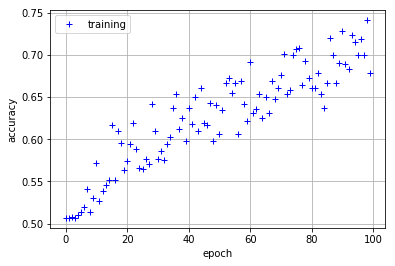

In [116]:
'''
q1a plot
'''
plt.plot(range(0, 100), epoch_accu_train[:, 0], 'b+', label = 'training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

In [117]:
'''
q1b
epoch vs accuracy on testing data
For each epoch number:
    use the perceptron weight estimatede from training data
    predict yhat = sign(w dp xi)
'''
# call epoch_accuracy_perceptron() function
epoch_accu_test = epoch_accuracy_perceptron(epoch_w_perc, test_x_y)

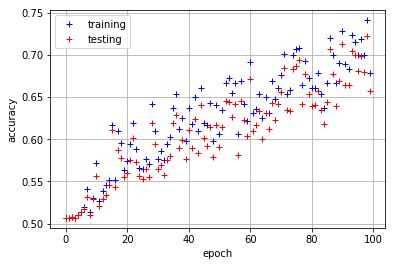

In [118]:
'''
q1b plot
'''
plt.plot(range(0, 100), epoch_accu_train[:, 0], 'b+', label = 'training')
plt.plot(range(0, 100), epoch_accu_test[:, 0], 'r+', label = 'testing')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

In [119]:
'''
q1c
accuracy and confusion matrix on testing data after the last epoch
'''
# predict test yhat for the last epoch
w = epoch_w_perc[-1, :]
yhat = predict_yhat(w, test_x_y)
# call performance()
accu, tp, fp, fn, tn = performance(test_x_y[:, -1].reshape(test_size, 1), yhat)
print('accuracy:', accu)
print('TP:', tp)
print('FP:', fp)
print('FN:', fn)
print('TN:', tn)

accuracy: 0.6569563033651431
TP: 299
FP: 0
FN: 683
TN: 1009


In [120]:
'''
q1d
calculate w_prime and w_star from perceptron
calculate ROC (FPR, TPR) pairs for w_prime and w_star
'''
# w
output = perceptron_m(train_x_y)
w_prime = output[0, :]
w_star = output[1, :]
# ROC
roc_prime = roc(w_prime, train_x_y, -200, 400, 0.5)
roc_star = roc(w_star, train_x_y, -200, 600, 0.5)

Perceptron maximum epoch is reached.


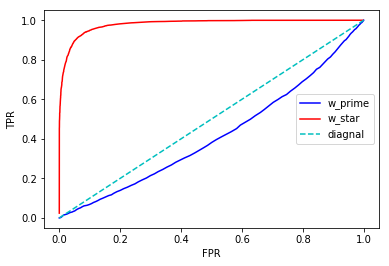

In [121]:
'''
q1d
plot ROC curves for w_prime and w_star
'''
plt.plot(roc_prime[:, 0], roc_prime[:, 1], 'b', label = 'w_prime')
plt.plot(roc_star[:, 0], roc_star[:, 1], 'r', label = 'w_star')
plt.plot([0, 0.5, 1], [0, 0.5, 1], 'c--', label = 'diagnal')
plt.legend(loc = 'right')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [122]:
'''
q1e
calculate AUC (area under ROC) for w_prime and w_star
'''
auc_prime = auc(roc_prime)
auc_star = auc(roc_star)
print('AUC for w_prime is', auc_prime)
print('AUC for w_star is', auc_star)

AUC for w_prime is 0.41607377087184255
AUC for w_star is 0.9771385482873396


In [123]:
'''
q2a
run balanced winnow on training data
get epoch wp and wn
compute accuracy for epochs
'''
# wp and wn vector for each epoch number from 0 to 99, shape = (100, 785)
epoch_wp_bw, epoch_wn_bw = balanced_winnow(train_x_y)
# accuracy number for each epoch number from 0 to 99, shape = (100, 1)
epoch_accu_bw_train = epoch_accuracy_winnow(epoch_wp_bw, epoch_wn_bw, train_x_y)

Balanced Winnow maximum epoch is reached.


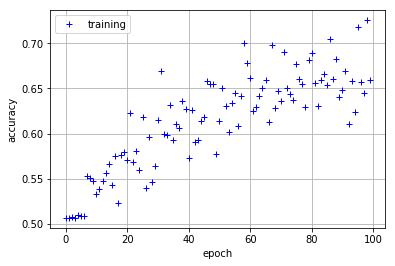

In [124]:
'''
q2a plot
'''
plt.plot(range(0, 100), epoch_accu_bw_train[:, 0], 'b+', label = 'training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

In [125]:
'''
q2a
accuracy and confusion matrix on the test set
accuracy = epoch_accu_test[-1, 1]
confusion matrix:
    TP = np.sum(yhat == 1 && test_x_y[-1] == 1)
    FP = np.sum(yhat == 1 && test_x_y[-1] == -1)
    FN = np.sum(yhat == -1 && test_x_y[-1] == 1)
    TN = np.sum(yhat == -1 && test_x_y[-1] == -1)
'''
# predict test yhat for the last epoch
wp = epoch_wp_bw[-1, :].reshape(785, 1)
wn = epoch_wn_bw[-1, :].reshape(785, 1)
yhat = np.dot(test_x_y[:, 0: 785], wp) - np.dot(test_x_y[:, 0: 785], wn)
yhat[yhat <= 0] = -1
yhat[yhat > 0] = 1
# call performance()
(accu, tp, fp, fn, tn) = performance(test_x_y[:, -1].reshape(test_size, 1), yhat)
# print results
print('accuracy:', str(accu))
print('TP:', str(tp))
print('FP:', str(fp))
print('FN:', str(fn))
print('TN:', str(tn))

accuracy: 0.6373681567051732
TP: 260
FP: 0
FN: 722
TN: 1009


In [128]:
'''
q2b
tune eta, and find the best eta

Thank God I've extracted out functions for calcuate epoch accuracy!!!!
'''
# first calculate epoch accuracy for eta = 0.1(in a), 0.2, 0.3, 0.4, 0.5
epoch_wp_bw_02, epoch_wn_bw_02 = balanced_winnow(train_x_y, 100, 0.2)
epoch_accu_bw_train_02 = epoch_accuracy_winnow(epoch_wp_bw_02, epoch_wn_bw_02, train_x_y)
epoch_wp_bw_03, epoch_wn_bw_03 = balanced_winnow(train_x_y, 100, 0.3)
epoch_accu_bw_train_03 = epoch_accuracy_winnow(epoch_wp_bw_03, epoch_wn_bw_03, train_x_y)
epoch_wp_bw_04, epoch_wn_bw_04 = balanced_winnow(train_x_y, 100, 0.4)
epoch_accu_bw_train_04 = epoch_accuracy_winnow(epoch_wp_bw_04, epoch_wn_bw_04, train_x_y)
epoch_wp_bw_05, epoch_wn_bw_05 = balanced_winnow(train_x_y, 100, 0.5)
epoch_accu_bw_train_05 = epoch_accuracy_winnow(epoch_wp_bw_05, epoch_wn_bw_05, train_x_y)

Balanced Winnow maximum epoch is reached.
Balanced Winnow maximum epoch is reached.
Balanced Winnow maximum epoch is reached.
Balanced Winnow maximum epoch is reached.


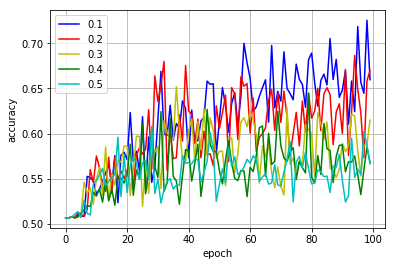

In [129]:
'''
q2b plot 1
'''
plt.plot(range(0, 100), epoch_accu_bw_train[:, 0], 'b', label = '0.1')
plt.plot(range(0, 100), epoch_accu_bw_train_02[:, 0], 'r', label = '0.2')
plt.plot(range(0, 100), epoch_accu_bw_train_03[:, 0], 'y', label = '0.3')
plt.plot(range(0, 100), epoch_accu_bw_train_04[:, 0], 'g', label = '0.4')
plt.plot(range(0, 100), epoch_accu_bw_train_05[:, 0], 'c', label = '0.5')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()

In [130]:
# based on previous results, calculate epoch accuracy for eta = 0.02, 0.04, 0.06, 0.08
epoch_wp_bw_002, epoch_wn_bw_002 = balanced_winnow(train_x_y, 100, 0.02)
epoch_accu_bw_train_002 = epoch_accuracy_winnow(epoch_wp_bw_002, epoch_wn_bw_002, train_x_y)
epoch_wp_bw_004, epoch_wn_bw_004 = balanced_winnow(train_x_y, 100, 0.04)
epoch_accu_bw_train_004 = epoch_accuracy_winnow(epoch_wp_bw_004, epoch_wn_bw_004, train_x_y)
epoch_wp_bw_006, epoch_wn_bw_006 = balanced_winnow(train_x_y, 100, 0.06)
epoch_accu_bw_train_006 = epoch_accuracy_winnow(epoch_wp_bw_006, epoch_wn_bw_006, train_x_y)
epoch_wp_bw_008, epoch_wn_bw_008 = balanced_winnow(train_x_y, 100, 0.08)
epoch_accu_bw_train_008 = epoch_accuracy_winnow(epoch_wp_bw_008, epoch_wn_bw_008, train_x_y)

Balanced Winnow maximum epoch is reached.
Balanced Winnow maximum epoch is reached.
Balanced Winnow maximum epoch is reached.
Balanced Winnow maximum epoch is reached.


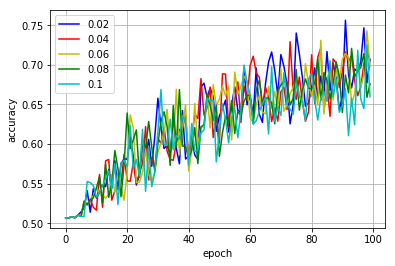

In [131]:
'''
q2b plot 2
'''
plt.plot(range(0, 100), epoch_accu_bw_train_002[:, 0], 'b', label = '0.02')
plt.plot(range(0, 100), epoch_accu_bw_train_004[:, 0], 'r', label = '0.04')
plt.plot(range(0, 100), epoch_accu_bw_train_006[:, 0], 'y', label = '0.06')
plt.plot(range(0, 100), epoch_accu_bw_train_008[:, 0], 'g', label = '0.08')
plt.plot(range(0, 100), epoch_accu_bw_train[:, 0], 'c', label = '0.1')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.show()